# <div style="background-color: lightblue; padding: 8px;">Melanoma Detection Assignment</div>

## Introduction:
- In this assignment, you will build a multiclass classification model using a custom convolutional neural network in TensorFlow..

## Problem Statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion


**Mount Gdrive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Skin Cancer Data**

##Importing libraries and packages

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras.models import Sequential
# Import the load_img function from Keras for loading images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers, models
# Import the Adam optimizer from Keras for optimization during model training
from tensorflow.keras.optimizers import Adam

# Import specific callback functions from Keras for model training callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping





## Data reading and understanding

In [3]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

# List the files in the training set and test set
print(f"Training files: {list(data_dir_train.glob('*'))}")
print(f"Testing files: {list(data_dir_test.glob('*'))}")

Training files: [PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic 

In [4]:
# Count the number of images in the training data set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
# Print the count of images in the training directory
print("Number of images in the training directory:", image_count_train)

# Count the number of images in the test data set
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
# Print the count of images in the test directory
print("Number of images in the test directory:", image_count_test)

Number of images in the training directory: 2239
Number of images in the test directory: 118


## Load using keras.preprocessing

## Create a dataset
**Define some parameters for the loader:**

In [5]:
batch_size = 32
img_height = 180
img_width = 180

**Using 80% of the images for training, and 20% for validation.**

In [6]:
## Using our train dataset here
## seed=123 while creating our dataset using tf.keras.preprocessing.image_dataset_from_directory

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## writing our validation dataset here

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## Writing our test dataset here
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data
Visualize one instance of all the nine classes present in the dataset

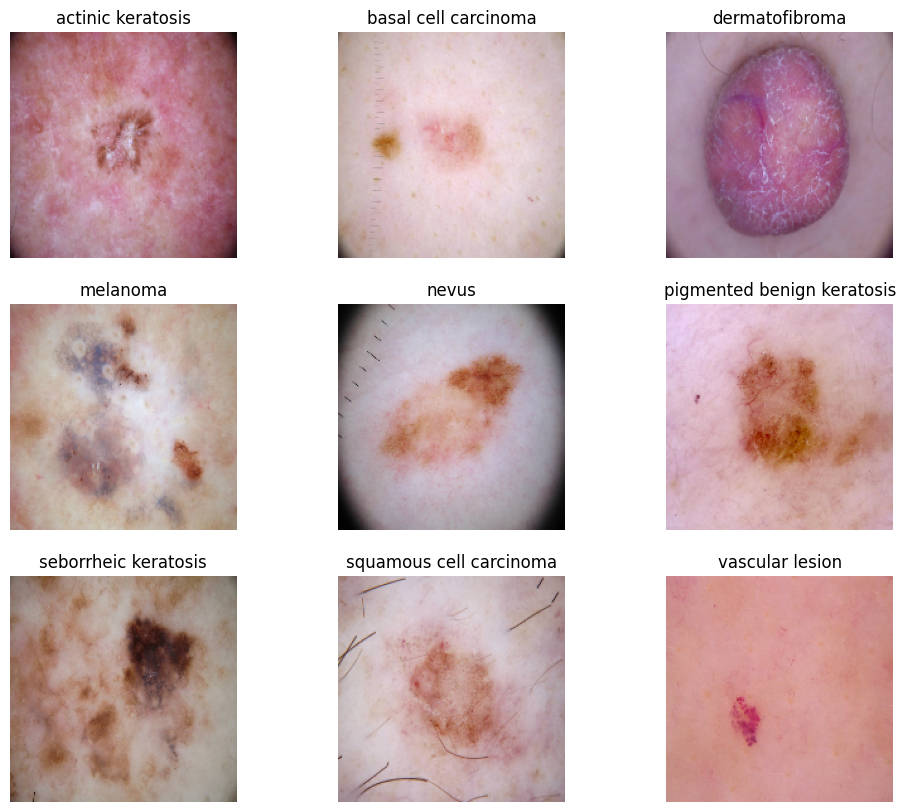

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.



In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Dataset.cache()** : keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** : overlaps data preprocessing and model execution while training.

## Create CNN model
Create a CNN model here, which can accurately detect 9 classes present in the dataset. Useing layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
num_classes = 9

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile the model**

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.2188 - loss: 2.0818 - val_accuracy: 0.3311 - val_loss: 1.9068
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3405 - loss: 1.8300 - val_accuracy: 0.4273 - val_loss: 1.7435
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4210 - loss: 1.6748 - val_accuracy: 0.4698 - val_loss: 1.5142
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4885 - loss: 1.4570 - val_accuracy: 0.4564 - val_loss: 1.4896
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5071 - loss: 1.3563 - val_accuracy: 0.4609 - val_loss: 1.5655
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5245 - loss: 1.3193 - val_accuracy: 0.5459 - val_loss: 1.3658
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5752 - loss: 1.1665 - val_accuracy: 0.5213 - val_loss: 1.4157
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5829 - loss: 1.1503 - val_accuracy: 0.5190 - v

## Visualizing training results

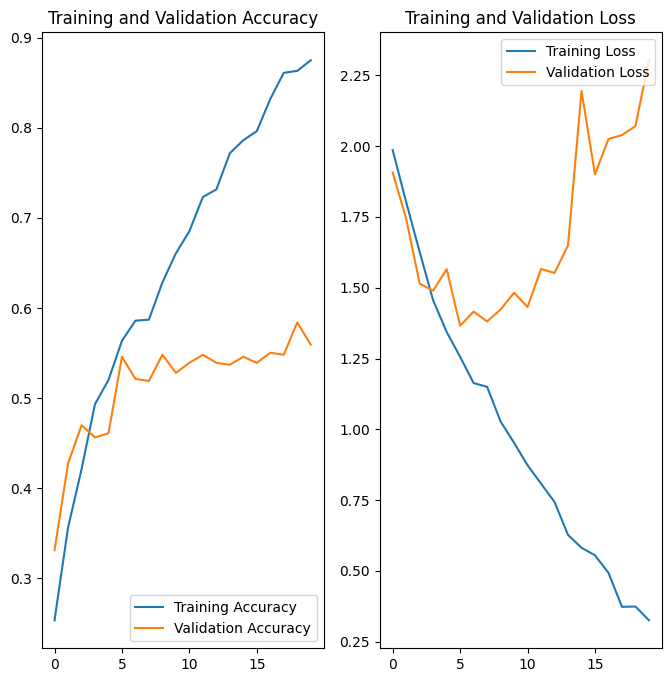

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Insights :**

**Training and Validation Accuracy Graph:**

1) Observe the overall trend of both training and validation accuracy curves. Ideally, both should increase over epochs.

2) A significant gap between training and validation accuracy indicates overfitting. This means the model is performing well on training data but poorly on unseen data.

**Training and Validation Loss Graph:**

1) The loss curves should generally decrease over epochs, indicating the model is learning and minimizing errors.

2) Similar to accuracy, a large gap between training and validation loss indicates overfitting.

we can observe that the validation accuracy of the model has achieved is around 55.93%, which is relatively low.
We need to apply techniques like Data Augmentation and Dropout to handle the overfitting issue of our model.

## Data Augmentation

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

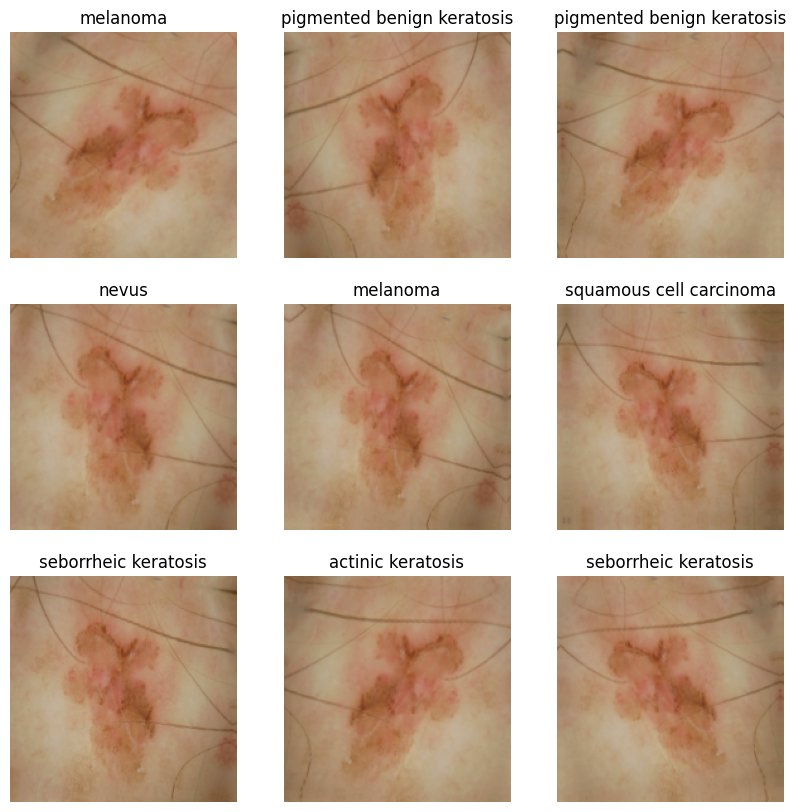

In [17]:
# visualize augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create the model, compile and train the model

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2094 - loss: 2.2111 - val_accuracy: 0.2573 - val_loss: 1.9648
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3170 - loss: 1.9049 - val_accuracy: 0.4049 - val_loss: 1.6710
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4089 - loss: 1.6512 - val_accuracy: 0.4787 - val_loss: 1.5027
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4638 - loss: 1.4816 - val_accuracy: 0.4049 - val_loss: 1.7272
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4571 - loss: 1.5258 - val_accuracy: 0.5347 - val_loss: 1.3663
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5207 - loss: 1.3619 - val_accuracy: 0.5302 - val_loss: 1.4733
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5437 - loss: 1.3065 - val_accuracy: 0.5190 - val_loss: 1.3822
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5334 - loss: 1.3228 - val_accuracy: 0.5123 - v

## Visualizing the results

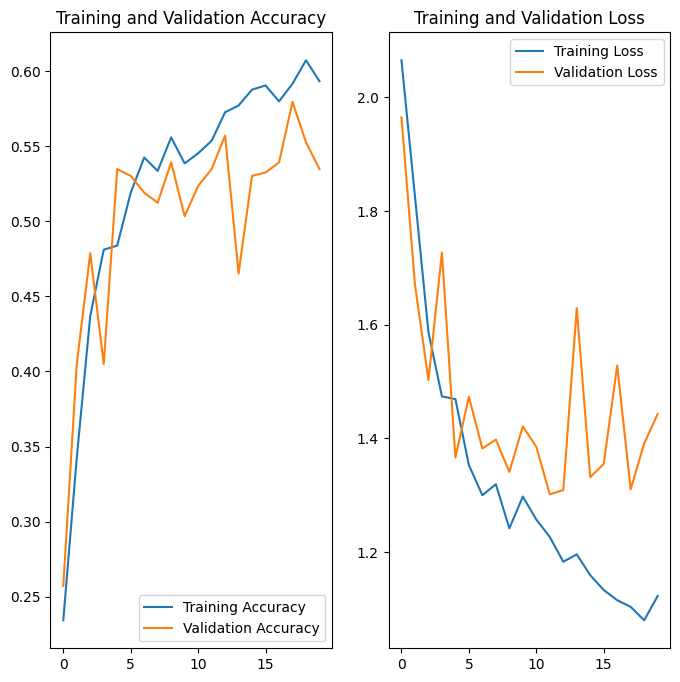

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Insights :**

The gap between the training and validation accuracy/loss curves has significantly reduced compared to the previous graph, and the highest accuracy achieved is around 58.89%. This indicates that data augmentation and dropout have helped in reducing overfitting, making the model generalize better to unseen data.
However, there is still scope for further to increase the accuracy of the model.

## Distribution of classes in the training dataset

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,/content/drive/My Drive/Skin cancer ISIC The I...,actinic keratosis
1,/content/drive/My Drive/Skin cancer ISIC The I...,actinic keratosis
2,/content/drive/My Drive/Skin cancer ISIC The I...,actinic keratosis
3,/content/drive/My Drive/Skin cancer ISIC The I...,actinic keratosis
4,/content/drive/My Drive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/drive/My Drive/Skin cancer ISIC The I...,melanoma
2235,/content/drive/My Drive/Skin cancer ISIC The I...,melanoma
2236,/content/drive/My Drive/Skin cancer ISIC The I...,melanoma
2237,/content/drive/My Drive/Skin cancer ISIC The I...,melanoma


Class=0, n=114 (5.092%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=7, n=181 (8.084%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=3, n=438 (19.562%)


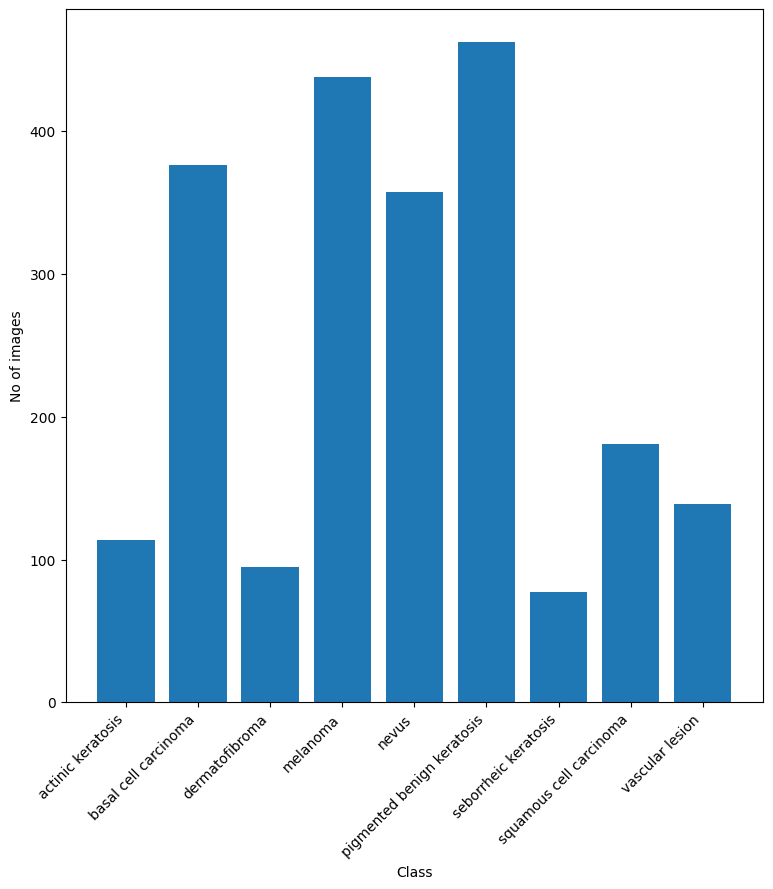

In [23]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(9,9))
plt.bar(class_names,count)
plt.xlabel("Class")
plt.ylabel("No of images")
plt.xticks(rotation=45, ha="right")
plt.show()


**Insights :**

**- Which class has the least number of samples?**

From the above bar chart we can see that the class Seborrheic keratosis have the least number of samples.

**- Which classes dominate the data in terms proportionate number of samples?**

We can observe that of all the class and found that the classes Pigmented benign keratosis,Melanoma,Nevus and Basal cell carcinoma has the most number of samples which dominate the data in terms proportionate number of samples.

## Rectify the class imbalance

In [24]:
#Install Augmentor

!pip install Augmentor

In [25]:
# Define the path to the training dataset
path_to_training_dataset = "/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Import the Augmentor library
import Augmentor

# Loop through each class and perform data augmentation
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i) # Create an Augmentor pipeline for the current class
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)# Apply rotation augmentation with specified parameters
    p.sample(500) ## 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC3624CBB20>: 100%|██████████| 500/500 [00:27<00:00, 17.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC340588850>: 100%|██████████| 500/500 [00:24<00:00, 20.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC35813CB20>: 100%|██████████| 500/500 [00:21<00:00, 23.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CC2E20AA530>: 100%|██████████| 500/500 [01:30<00:00,  5.53 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2725x2082 at 0x7CC35813CB20>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC3406F4E20>: 100%|██████████| 500/500 [00:22<00:00, 21.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CC2FD330E50>: 100%|██████████| 500/500 [00:45<00:00, 10.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC34017B880>: 100%|██████████| 500/500 [00:21<00:00, 23.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CC3401BEC20>: 100%|██████████| 500/500 [00:21<00:00, 22.90 Samples/s]


In [26]:
# Count the Total Number of Augmented Images Generated by Augmentor

# Count the number of image files in the 'output' subdirectories of each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

# Print the total count of augmented images
print("Total number of augmented images:", image_count_train)

Total number of augmented images: 4500


Checking the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_7a43fbdf-43ff-41da-bf6b-c4371ae0675f.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_d1a8bfe5-1669-46ae-87c9-209f9525c0a2.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_07f302b9-3640-4756-9cd2-a13aed353fbe.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_232c83a6-7f84-4dee-8318-09fb5b13f7a1.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_d0c3a826-7c63

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [31]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


## Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

## Create a training dataset

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## CNN Model

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [37]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 306ms/step - accuracy: 0.2636 - loss: 1.9509 - val_accuracy: 0.4343 - val_loss: 1.5077
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 267ms/step - accuracy: 0.4471 - loss: 1.4682 - val_accuracy: 0.4684 - val_loss: 1.4259
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/step - accuracy: 0.4843 - loss: 1.3724 - val_accuracy: 0.4967 - val_loss: 1.2994
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 251ms/step - accuracy: 0.4939 - loss: 1.3146 - val_accuracy: 0.5360 - val_loss: 1.2314
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 254ms/step - accuracy: 0.5253 - loss: 1.2190 - val_accuracy: 0.5605 - val_loss: 1.1498
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - accuracy: 0.5405 - loss: 1.1866 - val_accuracy: 0.5523 - val_loss: 1.1586
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - accuracy: 0.5593 - loss: 1.1377 - val_accuracy: 0.5746 - val_loss: 1.1000
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.5822 - loss: 1

## Visualize the model results

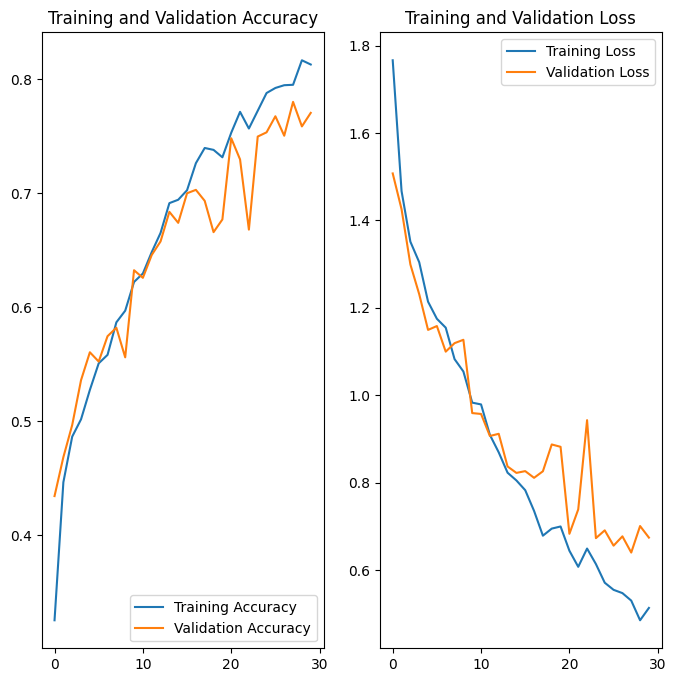

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1.The train accuracy and validation accuracy improved consistently with each epoch, peaking at 80.60% and 77.06% respectivly.

2.Validation loss decreased as the model learned, highlighting its ability to generalize well on unseen data.

3.The model demonstrated strong generalization, as evidenced by the consistent improvement in validation accuracy and reduction in validation loss.

4.These results suggest that the model effectively learned relevant features from the training data and successfully applied them to new images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


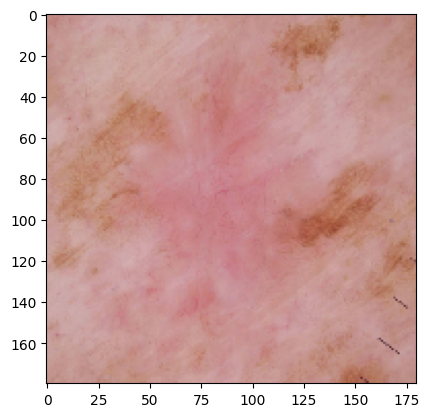

In [39]:
#Evaluate model on one of test instance

from glob import glob

# Construct the path to a test image
test_image_path = os.path.join(data_dir_test, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[2], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)